# Plot

> A collection of plot functions

In [ ]:
#| default_exp plot

In [ ]:
#| hide
import sys
sys.path.append('/notebooks/katlas')
from nbdev.showdoc import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
#| output: False
from katlas.feature import *
from katlas.core import *
from fastbook import *
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import logomaker
from matplotlib.ticker import MultipleLocator

import joblib
from adjustText import adjust_text
from pathlib import Path

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, AutocompleteInput, CustomJS
from bokeh.layouts import column
from itertools import cycle
from bokeh.palettes import Category20_20


In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

## Plot single kinase

### Logo

In [ ]:
#| export
def logo_func(df, 
              title = 'logo'):
    
    aa = {
        'AG': '#037f04',
        'DEsty': '#da143e', # sty essm to be the color as big ST&Y
        'F': '#84380b',
        'HQN': '#8d2be1',
        'LMIFWTVC': '#d9a41c',
        'P': '#000000',
        'RK': '#0000ff',
        'ST': '#8d008d',
        'Y': '#84380b',
        
        # 'st':'#8d2be1',
        # 'y':'#8d2be1'
        # 'pS/pT':'#8d2be1',
        # 'pY':'#8d2be1'
    }
    logo = logomaker.Logo(df,color_scheme = aa,flip_below=False,figsize=(7,2.5)) #5.5,2.5
    
    logo.style_xticks(fmt='%d')
    logo.ax.set_yticks([])
    logo.ax.set_title(title)

In [ ]:
#| export
def get_logo(df, # Stacked Dataframe with kinase as index, substrates as columns
             kinase, # A specific kinase name in index
               ):
    "Given stacked df (index as kinase, columns as substrates), get specific kinase's logo"
    
    
    #get raw kinase to calculate S/T
    pp = get_one_kinase(df,kinase,normalize=False)
    
    #get S/T ratio value
    ss = pp['S'].sum()
    st = pp['T'].sum()

    S_ctrl = 0.75*ss - 0.25*st
    T_ctrl = 0.75*st - 0.25*ss

    S0 = S_ctrl / max(S_ctrl, T_ctrl)
    T0 = T_ctrl / max(S_ctrl, T_ctrl)

    S_ratio = S0/(S0+T0)
    T_ratio = T0/(S0+T0)
    
    #get normalized kinase
    norm_p = get_one_kinase(df,kinase, normalize=True)
    
    ratio =norm_p.apply(lambda r: r/r.median(),axis=1)

    ratio = np.log2(ratio)

    m = ratio.apply(lambda row: row[row > 0].sum(), axis=1).max()

    new_row = pd.DataFrame({'S': S_ratio*m, 'T':T_ratio*m}, index=[0]) 

    ratio2 = pd.concat([ratio, new_row], ignore_index=False).fillna(0)
    
    #plot logo
    logo_func(ratio2, kinase)

In [ ]:
#| export
def get_logo2(full, title):
    S_ratio,T_ratio,Y_ratio = full[0][['s','t','y']]/full[0][['s','t','y']].sum()

    full = full.drop(columns=[0])
    
    # Identify the minimum value other than 0
    min_val = full[full > 0].min().min()
    # Replace 0s with the identified minimum value
    full = full.replace(0, min_val)

    norm_p = full.T

    ratio =norm_p.apply(lambda r: r-r.median(),axis=1)
#     ratio =norm_p.apply(lambda r: r/r.median(),axis=1)

#     ratio = np.log2(ratio)

    m = ratio.apply(lambda row: row[row > 0].sum(), axis=1).max()

    new_row = pd.DataFrame({'S': S_ratio*m, 'T':T_ratio*m,'Y':Y_ratio*m}, index=[0]) 

    ratio2 = pd.concat([ratio, new_row], ignore_index=False).fillna(0)

    logo_func(ratio2,title)

In [ ]:
raw = Data.get_stack_raw().set_index('kinase')

In [ ]:
raw.head(2)

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,7614134.38,2590563.43,3001315.49,4696631.43,4944311.77,8315837.72,10056545.00,16433061.43,10499735.53,9133577.86,4493053.86,10062728.22,3327454.51,3504742.95,2767294.24,10105742.33,5923673.04,2909152.87,1695155.97,1617848.59,2128670.48,2128670.48,6460994.89,5260312.92,6325834.43,6957993.77,5369434.90,5713920.54,6612201.68,6093662.03,6120308.98,7306988.18,6829677.84,5119221.55,5263235.93,3974771.07,5065007.89,7968511.43,7041049.08,6174443.51,4228327.20,3271230.67,5511933.84,3267817.62,3267817.62,3338569.94,8921287.46,4210322.63,9202467.84,5247517.95,6741480.38,6810877.54,5271476.43,4928031.78,4337561.80,6432256.95,4006022.34,3383022.36,3493591.45,3269349.53,4253143.83,4777087.04,5719013.51,4787112.42,2233864.71,3045337.18,2489664.19,2489664.19,2253600.17,2216028.59,2766177.13,5269960.36,5606488.15,5715776.94,8442376.88,3330815.96,3699660.08,5573758.37,11418739.19,3289921.82,3904724.03,2831767.59,5548344.99,5749698.72,5431820.79,14853623.17,7911791.51,7877660.92,6228872.38,2050311.16,2050311.16,4757608.56,12743566.74,7922825.91,4320088.81,3424101.65,2951131.47,3531424.24,4395648.71,4876361.62,7337788.35,6213208.09,6110446.84,8716736.64,4935259.96,7723412.28,13791485.68,10359621.72,4456718.79,4865705.32,1811253.16,1639403.12,1357999.07,1357999.07,2002371.19,6415286.88,99964895.25,4316874.96,3007074.62,2745785.51,8910120.32,1483692.44,1412340.64,1811600.47,1711244.81,1783236.05,1979521.48,2246919.31,2217612.04,2688447.64,3450817.64,1911929.56,2358432.64,1421652.45,1359587.84,1706013.09,1706013.09,1389641.63,5119157.71,7278540.04,7284322.40,6474714.78,8229140.75,31325167.00,5271194.4,3595811.04,4019474.24,4672000.36,4719445.91,4458958.54,5560394.09,6019747.75,5603858.75,7520620.82,7492737.30,8100331.77,5364638.21,5087031.12,3976345.18,3976345.18,3984759.21,7873214.56,10666925.10,6726092.35,8347110.75,8474126.59,36243425.13,7049439.08,4480458.41,5646461.38,5049205.04,4966940.21,6154422.64,5554384.65,7784625.71,8536454.84,10411516.21,7199439.88,8496115.61,4678462.79,4293019.55,3871242.35,3871242.35,4144314.24,6754640.94,7548893.13,6945441.59,6316583.85,5852227.64,11986373.78,4544765.44,4468425.80,4958371.35,4992757.20,5630292.14,5605199.37,8889242.83,6020662.73,8938081.41,9983402.01,6833481.55,6364453.29,4189045.89,4921595.57,2705053.53,2705053.53,2909279.71
ACVR2A,4991039.28,5783855.86,7015770.78,8367603.09,7072052.48,7601399.57,7188292.41,7513915.73,7159894.71,6266122.81,7217726.01,6944709.95,9655463.75,6855044.90,6135259.88,5714942.29,5174360.28,6446237.55,10676798.47,9490370.51,9417512.45,9417512.45,9143262.67,5189500.90,6115977.27,6183207.45,8746774.91,8620216.35,8958568.82,6057960.27,5865979.65,5795429.17,6425254.28,6896823.79,6528270.38,8404648.40,6144455.59,4524121.26,5095303.46,5374811.94,5585576.72,11592053.32,9685649.12,9011965.48,9011965.48,7594632.10,5362570.64,6972103.63,5730145.40,8939563.00,8882396.89,9190426.82,5827104.19,5369092.23,5113057.94,5497993.14,5506587.16,5872246.52,6306875.17,5653091.40,3785783.33,4917762.58,5423081.45,5362812.26,11212957.52,12861894.95,12864905.98,128

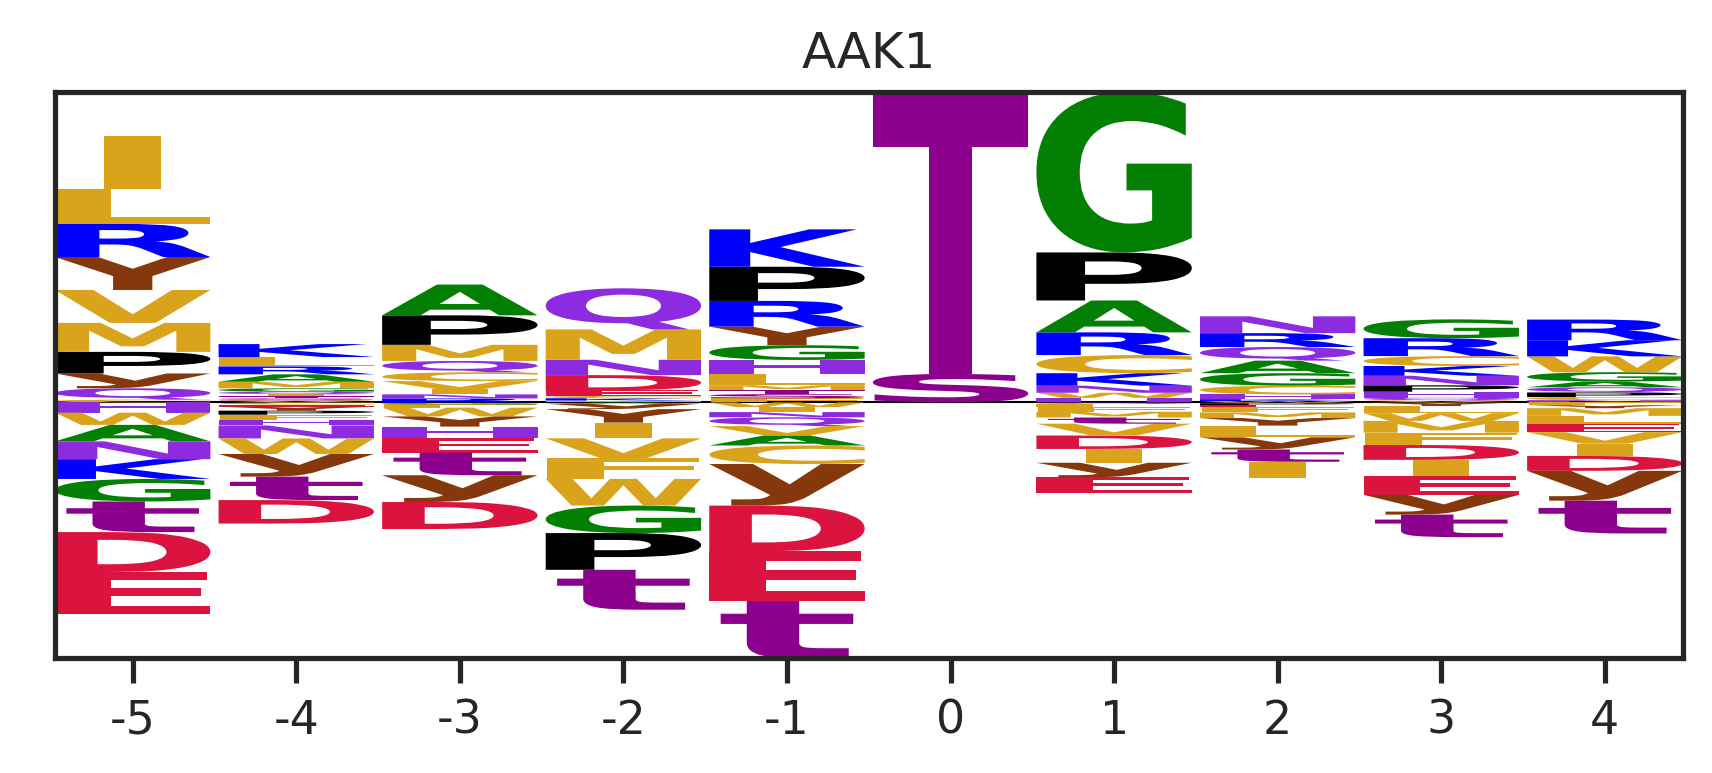

In [ ]:
get_logo(raw, 'AAK1')

### Rank

In [ ]:
#| export
def plot_rank(sorted_df, x, y, n_hi=10,n_lo=10,figsize=(10,8),**kwargs):

    plt.figure(figsize=figsize)
    sorted_df = sorted_df.reset_index(drop=True)
    sns_plot = sns.scatterplot(data=sorted_df, 
                               x = x,
                               y = y, **kwargs)

    sns_plot.set_xticks([])
    
    
    texts = []
    
    # Annotate the highest n values
    if n_hi is not None:
        
        for i, row in sorted_df.head(n_hi).iterrows():
            texts.append(plt.text(i, row[y], row[x], ha='center', va='bottom'))

    if n_lo is not None:
        # Annotate the lowest n values
        n_lowest = n_lo
        for i, row in sorted_df.tail(n_lowest).iterrows():
            texts.append(plt.text(i, row[y], row[x], ha='center', va='bottom'))
            
    if len(texts)>0:
        # Use adjustText to adjust text positions
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

    plt.tight_layout()

### Histogram

In [ ]:
#| export
def plot_hist(df,x,figsize=(6,2),**kwargs):
    
    hist_params = {'element':'poly',
              'edgecolor': None,
              'alpha':0.5,
              'bins':100,
              'kde':True}
    
    plt.figure(figsize=figsize)
    sns.histplot(data=df,x=x,**hist_params,**kwargs)

### Heatmap

In [ ]:
#| export
def get_heatmap(df, # Stacked Dataframe with kinase as index, substrates as columns
                kinase # A specific kinase name in index
               ):
    aa_order = [i for i in 'PGACSTVILMFYWHKRQNDEty']
    # position_order = [str(i) for i in range(-5,5)]
    # position_order.remove('0')
    
    kk = get_one_kinase(df, kinase).T
    # kkk = kk.reindex(index=aa_order, columns=position_order)
    kkk = kk.reindex(index=aa_order)
    
    plt.figure(figsize=(6, 10))
    sns.heatmap(kkk, cmap='binary', annot=False)
    plt.title(kinase)

In [ ]:
#| export
def plot_heatmap(matrix,title,figsize=(6,10)):
    
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, cmap='binary', annot=False)
    plt.title(title)

In [ ]:
raw.head(2)

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,7614134.38,2590563.43,3001315.49,4696631.43,4944311.77,8315837.72,10056545.00,16433061.43,10499735.53,9133577.86,4493053.86,10062728.22,3327454.51,3504742.95,2767294.24,10105742.33,5923673.04,2909152.87,1695155.97,1617848.59,2128670.48,2128670.48,6460994.89,5260312.92,6325834.43,6957993.77,5369434.90,5713920.54,6612201.68,6093662.03,6120308.98,7306988.18,6829677.84,5119221.55,5263235.93,3974771.07,5065007.89,7968511.43,7041049.08,6174443.51,4228327.20,3271230.67,5511933.84,3267817.62,3267817.62,3338569.94,8921287.46,4210322.63,9202467.84,5247517.95,6741480.38,6810877.54,5271476.43,4928031.78,4337561.80,6432256.95,4006022.34,3383022.36,3493591.45,3269349.53,4253143.83,4777087.04,5719013.51,4787112.42,2233864.71,3045337.18,2489664.19,2489664.19,2253600.17,2216028.59,2766177.13,5269960.36,5606488.15,5715776.94,8442376.88,3330815.96,3699660.08,5573758.37,11418739.19,3289921.82,3904724.03,2831767.59,5548344.99,5749698.72,5431820.79,14853623.17,7911791.51,7877660.92,6228872.38,2050311.16,2050311.16,4757608.56,12743566.74,7922825.91,4320088.81,3424101.65,2951131.47,3531424.24,4395648.71,4876361.62,7337788.35,6213208.09,6110446.84,8716736.64,4935259.96,7723412.28,13791485.68,10359621.72,4456718.79,4865705.32,1811253.16,1639403.12,1357999.07,1357999.07,2002371.19,6415286.88,99964895.25,4316874.96,3007074.62,2745785.51,8910120.32,1483692.44,1412340.64,1811600.47,1711244.81,1783236.05,1979521.48,2246919.31,2217612.04,2688447.64,3450817.64,1911929.56,2358432.64,1421652.45,1359587.84,1706013.09,1706013.09,1389641.63,5119157.71,7278540.04,7284322.40,6474714.78,8229140.75,31325167.00,5271194.4,3595811.04,4019474.24,4672000.36,4719445.91,4458958.54,5560394.09,6019747.75,5603858.75,7520620.82,7492737.30,8100331.77,5364638.21,5087031.12,3976345.18,3976345.18,3984759.21,7873214.56,10666925.10,6726092.35,8347110.75,8474126.59,36243425.13,7049439.08,4480458.41,5646461.38,5049205.04,4966940.21,6154422.64,5554384.65,7784625.71,8536454.84,10411516.21,7199439.88,8496115.61,4678462.79,4293019.55,3871242.35,3871242.35,4144314.24,6754640.94,7548893.13,6945441.59,6316583.85,5852227.64,11986373.78,4544765.44,4468425.80,4958371.35,4992757.20,5630292.14,5605199.37,8889242.83,6020662.73,8938081.41,9983402.01,6833481.55,6364453.29,4189045.89,4921595.57,2705053.53,2705053.53,2909279.71
ACVR2A,4991039.28,5783855.86,7015770.78,8367603.09,7072052.48,7601399.57,7188292.41,7513915.73,7159894.71,6266122.81,7217726.01,6944709.95,9655463.75,6855044.90,6135259.88,5714942.29,5174360.28,6446237.55,10676798.47,9490370.51,9417512.45,9417512.45,9143262.67,5189500.90,6115977.27,6183207.45,8746774.91,8620216.35,8958568.82,6057960.27,5865979.65,5795429.17,6425254.28,6896823.79,6528270.38,8404648.40,6144455.59,4524121.26,5095303.46,5374811.94,5585576.72,11592053.32,9685649.12,9011965.48,9011965.48,7594632.10,5362570.64,6972103.63,5730145.40,8939563.00,8882396.89,9190426.82,5827104.19,5369092.23,5113057.94,5497993.14,5506587.16,5872246.52,6306875.17,5653091.40,3785783.33,4917762.58,5423081.45,5362812.26,11212957.52,12861894.95,12864905.98,128

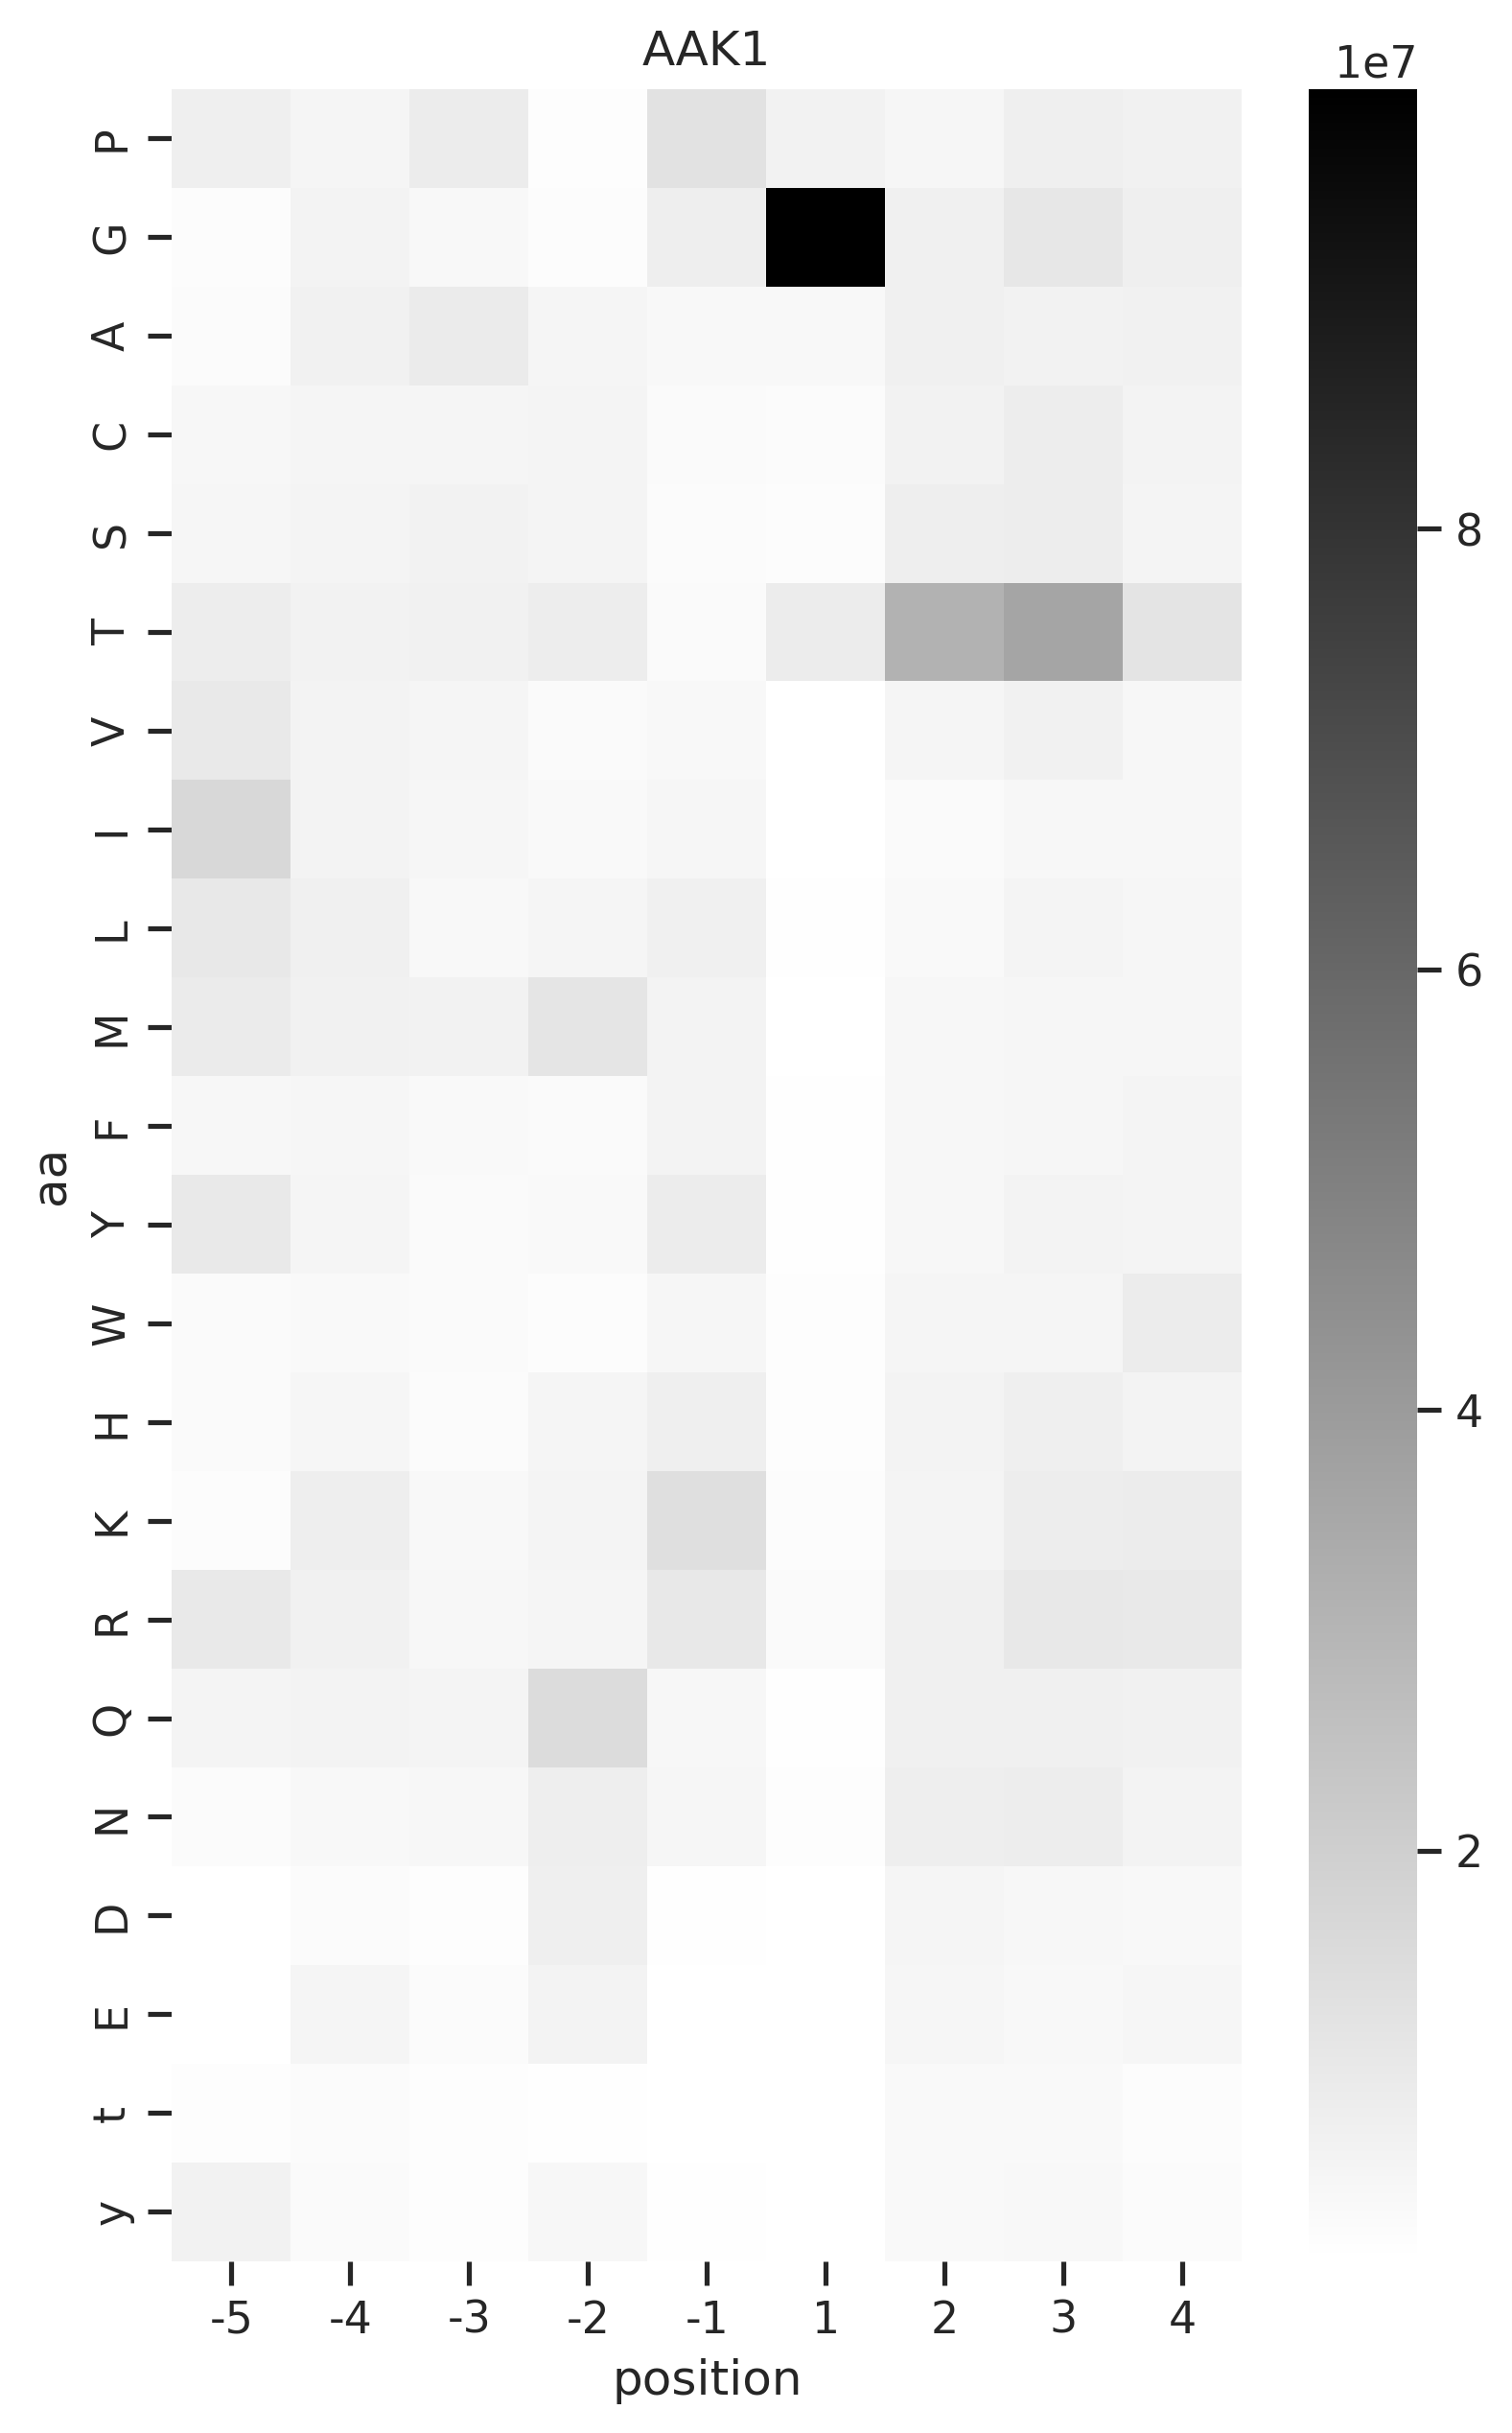

In [ ]:
get_heatmap(raw, 'AAK1')

## Visualize features in 2D

In [ ]:
#| export
def plot_2d(X,**kwargs):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data = X,x=X.columns[0],y=X.columns[1],s=3,alpha=0.7,**kwargs)

In [ ]:
#| export
def plot_cluster(df, # a dataframe with values, and index as identity
                 method='pca', # Could be 'tsne', 'umap'
                 hue=None,
                 complexity = 30, # 30 for tsne, 15 for umap, none for pca
                 palette='tab20', # could be tab10 if less categories
                 legend=False, 
                 name_list=None, # if not none, will annotate each dots in the plot
                 seed = 123, 
                  s = 50,
                  **kwargs
                ):
    
    "Given a dataframe of values, plot it in 2d, method could be pca, tsne, or umap"
    
    embedding_df = reduce_feature(df, method=method, seed=seed, complexity = complexity,**kwargs)
    # x_col, y_col = [col for col in embedding_df.columns if col.startswith(method.upper())]
    x_col, y_col = embedding_df.columns
    sns.relplot(data=embedding_df, x=x_col, y=y_col, hue=hue, palette=palette, s=s, alpha=0.8, legend=legend)
    plt.xticks([])
    plt.yticks([])
    if name_list is not None:
        texts = [plt.text(embedding_df[x_col][i], embedding_df[y_col][i], name_list[i],fontsize=8) for i in range(len(embedding_df))]
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

In [ ]:
df = Data.get_aa_feature()
info=Data.get_aa_info()

In [ ]:
df.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,MinPartialCharge,MaxAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0n,Chi0v,Chi1,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,NHOHCount,NOCount,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,RingCount,MolLogP,fr_Al_COO,fr_Al_OH,fr_Ar_N,fr_C_O,fr_NH0,fr_NH1,fr_NH2,fr_SH,fr_imidazole,fr_priamide,fr_sulfide,fr_unbrch_alkane
aa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,9.574074,0.731481,-0.962963,0.451352,89.094,-0.480094,0.480094,2.000000,2.166667,2.166667,16.367425,10.385341,1.990289,-1.897069,1.676610,-2.250004,-0.137563,1.360964,3.257586,59.813538,3.510162,3.510162,2.642734,1.627090,1.126913,1.126913,0.389528,0.389528,0.000000,0.000000,-0.57,13.609640,5.430000,1.767634,1.721545,10.840195,6.041841,0.0,0.0,5.969305,4.794537,0.0,0.000000,0.000000,6.923737,0.000000,0.000000,9.901065,5.969305,0.0,5.733667,12.965578,0.000000,0.000000,0.0,5.733667,17.117674,4.794537,0.0,6.923737,0.0,63.32,12.011146,4.794537,0.000000,0.000000,0.000000,6.923737,0.0,0.000000,0.000000,10.840195,0.000000,9.574074,7.865741,4.835648,-0.962963,-0.731481,0.000000,1.418981,0.0,0.666667,3.0,3.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,1.0,0.0,-0.5818,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
C,9.756435,0.189815,-1.004630,0.424382,121.161,-0.480064,0.480064,2.000000,2.428571,2.428571,32.116867,10.376545,2.056705,-1.960761,1.795249,-2.309520,-0.137419,1.645711,3.343417,75.335159,3.664483,4.558910,3.180739,2.406671,1.127305,1.492453,0.513894,0.907286,0.078093,0.234278,-0.22,27.977093,6.780000,2.872925,2.472042,10.840195,6.041841,0.0,0.0,5.969305,4.794537,0.0,12.628789,0.000000,0.000000,5.752854,0.000000,9.901065,18.598094,0.0,5.733667,6.041841,5.752854,0.000000,0.0,5.733667,22.870527,4.794537,0.0,0.000000,0.0,63.32,12.011146,4.794537,5.752854,0.000000,0.000000,0.000000,0.0,0.000000,12.628789,10.840195,3.649043,9.756435,8.008102,4.939815,-0.814815,-0.816358,0.000000,0.000000,0.0,0.666667,3.0,3.0,0.0,0.0,0.0,0.0,3.0,3.0,4.0,2.0,0.0,-0.6719,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
D,9.846435,0.532407,-1.294074,0.452021,133.103,-0.481175,0.481175,1.444444,1.888889,2.000000,16.374460,10.219121,2.138971,-1.985360,1.855319,-2.318388,-0.144488,1.634374,3.632432,132.529325,4.572731,4.572731,4.036581,2.239272,1.542593,1.542593,0.711731,0.711731,0.275438,0.275438,-1.10,60.471844,7.900000,3.032307,3.479710,15.946722,6.041841,0.0,0.0,11.938611,9.589074,0.0,0.000000,0.000000,0.000000,0.000000,6.420822,19.802129,11.938611,0.0,5.733667,12.462662,0.000000,0.000000,0.0,5.733667,28.193506,9.589074,0.0,6.420822,0.0,100.62,24.401273,9.589074,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,15.946722,0.000000,19.617269,16.031991,4.837037,-2.497870,-1.289352,-0.532407,0.000000,0.0,0.500000,4.0,5.0,0.0,0.0,0.0,0.0,3.0,3.0,5.0,3.0,0.0,-1.1270,2.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
E,9.993880,0.023148,-1.165509,0.485976,147.130,-0.481229,0.481229,1.400000,1.900000,2.200000,16.370713,10.159875,2.115643,-2.009303,1.929131,-2.299667,-0.139392,1.820357,3.490730,144.583377,5.279838,5.279838,4.536581,2.739272,1.877144,1.877144,0.986405,0.986405,0.402453,0.402453,-1.10,111.041752,

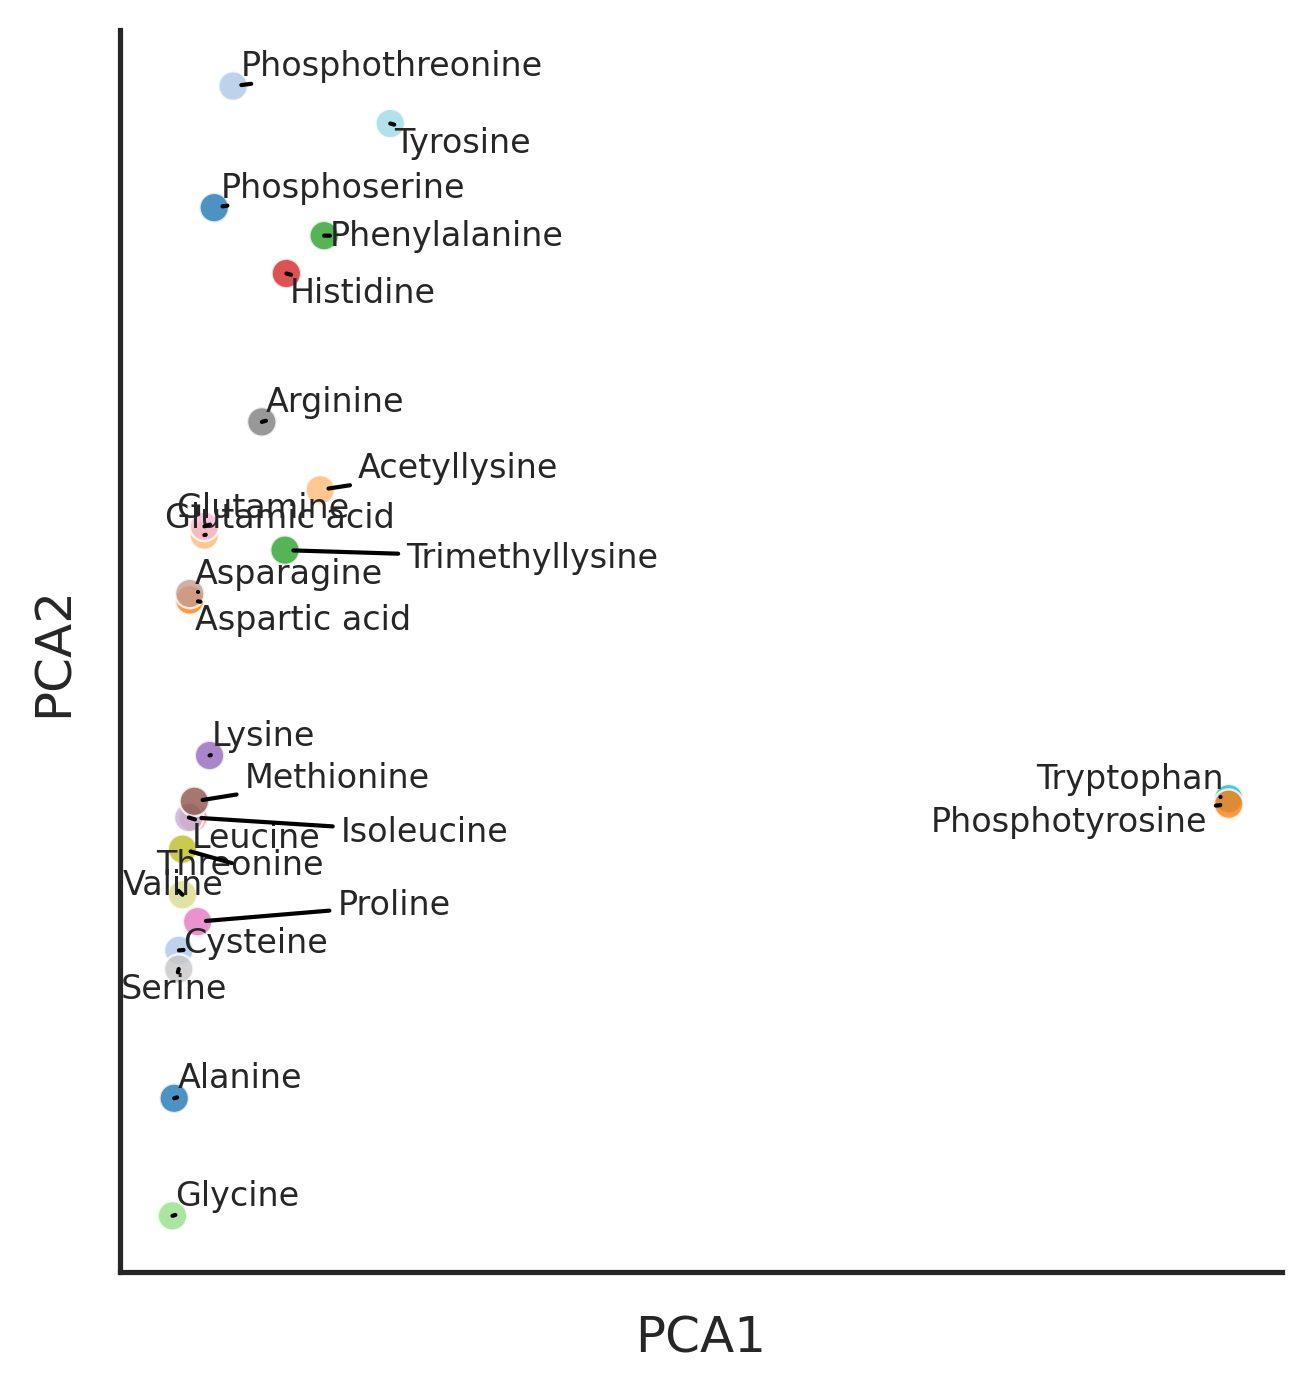

In [ ]:
plot_cluster(df, name_list = info.Name,hue='aa')

## Interactive plot

In [ ]:
#| export
def assign_colors(categories, palette):
    "assign colors to category in a dataframe, returns the same length of df"
    color_cycle = cycle(palette)
    color_map = {category: next(color_cycle) for category in categories}
    return [color_map[category] for category in categories]

In [ ]:
#| export
def get_color_dict(categories, palette='tab20'):
    "assign colors to category in a dataframe, returns the same length of df"
    p=sns.color_palette(palette)
    color_cycle = cycle(p)
    color_map = {category: next(color_cycle) for category in categories}
    return color_map

In [ ]:
#| export
def plot_bokeh(X, 
               idx:list, # identities for searching box & autocompletion
               colors=None,
               s=3, **kwargs):
    
    output_notebook()
    if colors is not None:
        colors  = colors
    else:
        colors = ['navy'] * len(X)
        
    
    data_dict={
    'x': X.iloc[:,0],
    'y': X.iloc[:,1],
    'identity': idx,
    'color': colors,
    'original_color': colors,
    'size': [s] * len(X), 
    'highlighted': ['no'] * len(X)  # To keep track of which dot is highlighted
    }
    
    for key, value in kwargs.items():
        data_dict[key] = value
    
    source = ColumnDataSource(data=data_dict)
    
    p = figure(tools="pan,box_zoom,wheel_zoom,reset")
    p.scatter('x', 'y', source=source, alpha=0.6, color='color', size='size')

    # Disable grid lines
    p.xgrid.visible = False
    p.ygrid.visible = False
    
    # Add hover tool
    hover = HoverTool()
    
    tooltips = [("Identity", "@identity")]

    for key in kwargs.keys():
        tooltips.append((key.capitalize(), f"@{key}"))

    
    hover.tooltips = tooltips
    p.add_tools(hover)
    
    
    autocomplete = AutocompleteInput(title="Search by Identity:", completions=idx)

    callback = CustomJS(args=dict(source=source, plot=p), code="""
        const data = source.data;
        const search_val = cb_obj.value.toLowerCase();
        const x = data['x'];
        const y = data['y'];
        const identity = data['identity'];
        const color = data['color'];
        const original_color = data['original_color'];
        const size = data['size'];
        const highlighted = data['highlighted'];

        for (let i = 0; i < identity.length; i++) {
            if (highlighted[i] === 'yes') {
                color[i] = original_color[i];
                size[i] = 10;
                highlighted[i] = 'no';
            }
            if (identity[i].toLowerCase() === search_val) {
                plot.x_range.start = x[i] - 5;
                plot.x_range.end = x[i] + 5;
                plot.y_range.start = y[i] - 5;
                plot.y_range.end = y[i] + 5;
                color[i] = 'red';
                size[i] = 15;
                highlighted[i] = 'yes';
            }
        }
        source.change.emit();
    """)
    autocomplete.js_on_change('value', callback)

    # Show layout
    layout = column(autocomplete, p)
    show(layout)

In [ ]:
#| export
def plot_bokeh_category(X, 
               idx:list, # identities for searching box
               cat=None, # categories to color
               s=3, **kwargs):
        
    output_notebook()
    if cat is not None:
        colors  = assign_colors(cat, Category20_20)
    else:
        colors = ['navy'] * len(X)
        
    
    data_dict={
    'x': X.iloc[:,0],
    'y': X.iloc[:,1],
    'identity': idx,
    'color': colors,
    'original_color': colors,
    'size': [s] * len(X), 
    'highlighted': ['no'] * len(X)  # To keep track of which dot is highlighted
    }
    
    for key, value in kwargs.items():
        data_dict[key] = value
    
    source = ColumnDataSource(data=data_dict)
    
    p = figure(tools="pan,box_zoom,wheel_zoom,reset")
    p.scatter('x', 'y', source=source, alpha=0.6, color='color', size='size')

    # Disable grid lines
    p.xgrid.visible = False
    p.ygrid.visible = False
    
    # Add hover tool
    hover = HoverTool()
    
    tooltips = [("Identity", "@identity")]

    for key in kwargs.keys():
        tooltips.append((key.capitalize(), f"@{key}"))

    
    hover.tooltips = tooltips
    p.add_tools(hover)
    
    
    autocomplete = AutocompleteInput(title="Search by Identity:", completions=idx)

    callback = CustomJS(args=dict(source=source, plot=p), code="""
        const data = source.data;
        const search_val = cb_obj.value.toLowerCase();
        const x = data['x'];
        const y = data['y'];
        const identity = data['identity'];
        const color = data['color'];
        const original_color = data['original_color'];
        const size = data['size'];
        const highlighted = data['highlighted'];

        for (let i = 0; i < identity.length; i++) {
            if (highlighted[i] === 'yes') {
                color[i] = original_color[i];
                size[i] = 10;
                highlighted[i] = 'no';
            }
            if (identity[i].toLowerCase() === search_val) {
                plot.x_range.start = x[i] - 5;
                plot.x_range.end = x[i] + 5;
                plot.y_range.start = y[i] - 5;
                plot.y_range.end = y[i] + 5;
                color[i] = 'red';
                size[i] = 15;
                highlighted[i] = 'yes';
            }
        }
        source.change.emit();
    """)
    autocomplete.js_on_change('value', callback)

    # Show layout
    layout = column(autocomplete, p)
    show(layout)

In [ ]:
X = reduce_feature(df)

In [ ]:
plot_bokeh(X, 
           idx = info.Name.tolist(),
           cat = info.Name.tolist(),
           s=7, 
           smiles = info.SMILES)

Loading BokehJS ...

In [ ]:
plot_bokeh_category(X, 
           idx = info.Name.tolist(),
           cat = info.Name.tolist(),
           s=7, 
           smiles = info.SMILES)

Loading BokehJS ...

## Bar graph

In [ ]:
#| export
def plot_count(cnt,tick_spacing = None,palette='tab20'):

    c = sns.color_palette(palette)
    ax = cnt.plot.barh(color = c)

    for index, value in enumerate(cnt):
        plt.text(value, index, str(value),fontsize=10,rotation=-90, va='center')
        # Set x-ticks at regular intervals
    if tick_spacing is not None:
        ax.xaxis.set_major_locator(MultipleLocator(tick_spacing))

In [ ]:
#| export
def plot_bar(df, # dataframe with a column of values, and a column of category to groupby
             values, # colname of values
             category, # colname of categories which is used to groupby values
             circle = True, # whether or not add dots in the graph
             aspect = 3, # the biger the value is, the wider the graph is
             rotation=45,
             **kwargs
              ):
    
    order = df.groupby(category)[values].mean().sort_values(ascending=False).index
    g = sns.catplot(data=df,
                x=category,
                y=values,
                aspect=aspect,
                order=order,
                kind='bar',
                ci='sd',
                **kwargs)
    g.set_xticklabels(rotation=rotation)
    
    if circle:
        marker = {'marker': 'o', 
                  'color': 'white', 
                  'edgecolor': 'black', 
                  'linewidth': 1.5, 
                  's': 6}

        sns.stripplot(data=df, 
                      x=category, 
                      y=values,
                      order=order,
                      alpha=0.8,
                      ax=g.ax,
                      **marker);

In [ ]:
df2 = Data.get_unstack_log()

In [ ]:
df2.head()

,kinase,substrate,target,position,aa
0,AAK1,-5P,15.845517,-5,P
1,ACVR2A,-5P,15.423155,-5,P
2,ACVR2B,-5P,17.091913,-5,P
3,AKT1,-5P,16.727835,-5,P
4,AKT2,-5P,15.509150,-5,P


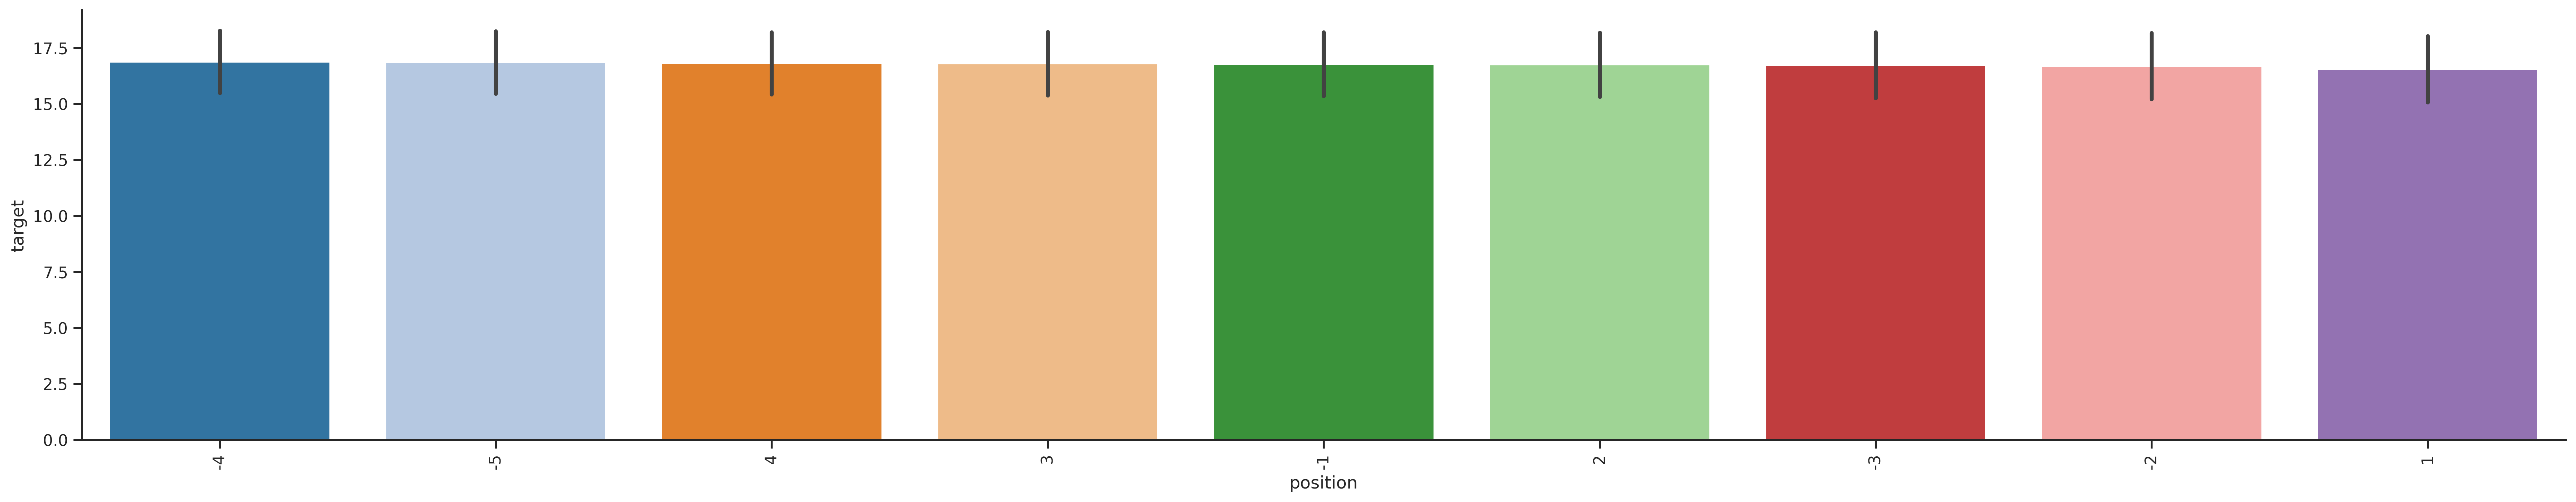

In [ ]:
plot_bar(df2,values='target',category='position',circle=False,aspect=5,rotation=90,palette='tab20')

## Correlation graph with regression line

In [ ]:
#| export
def plot_corr(
              x,
              y,
              xlabel=None,# x axis label
              ylabel=None,# y axis label
            data = None,
            text_location = [0.8,0.1],
            **kwargs
             ):
    "Given a dataframe and the name of two columns, plot the two columns' correlation"
    if data is not None:
        x=data[x]
        y=data[y]
        
    pear, pvalue = pearsonr(x, y)
        
    sns.regplot(
                x=x,
                y=y,
                line_kws={'color': 'gray'}, **kwargs
           )
    
    if xlabel is not None:
        plt.xlabel(xlabel)
        
    if ylabel is not None:
        plt.ylabel(ylabel)
    
    # correlation_text = f'Spearman: {correlation:.2f}' if method == 'spearman' else f'Pearson: {correlation:.2f}'

    # plt.text(x=0.8, y=0.1, s=correlation_text, transform=plt.gca().transAxes, ha='center', va='center')
    plt.text(s=f'Pearson = {round(pear,2)}\n   p = {"{:.2e}".format(pvalue)}',
             x=text_location[0],y=text_location[1],
            transform=plt.gca().transAxes, 
             ha='center', va='center')

In [ ]:
norm = Data.get_stack_norm().set_index('kinase')

In [ ]:
norm.head()

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,0.0720,0.0245,0.0284,0.0456,0.0425,0.0425,0.0951,0.1554,0.0993,0.0864,0.0425,0.0952,0.0315,0.0331,0.0262,0.0956,0.0560,0.0275,0.0160,0.0153,0.0201,0.0201,0.0611,0.0534,0.0642,0.0706,0.0560,0.0619,0.0619,0.0619,0.0621,0.0742,0.0693,0.0520,0.0534,0.0403,0.0514,0.0809,0.0715,0.0627,0.0429,0.0332,0.0560,0.0332,0.0332,0.0339,0.1084,0.0512,0.1119,0.0655,0.0527,0.0527,0.0641,0.0599,0.0527,0.0782,0.0487,0.0411,0.0425,0.0397,0.0517,0.0581,0.0695,0.0582,0.0272,0.0370,0.0303,0.0303,0.0274,0.0226,0.0283,0.0538,0.0588,0.0555,0.0555,0.0340,0.0378,0.0569,0.1166,0.0336,0.0399,0.0289,0.0567,0.0587,0.0555,0.1517,0.0808,0.0805,0.0636,0.0209,0.0209,0.0486,0.1136,0.0706,0.0385,0.0313,0.0545,0.0545,0.0392,0.0435,0.0654,0.0554,0.0545,0.0777,0.0440,0.0688,0.1229,0.0923,0.0397,0.0434,0.0161,0.0146,0.0121,0.0121,0.0178,0.0463,0.7216,0.0312,0.0223,0.0143,0.0143,0.0107,0.0102,0.0131,0.0124,0.0129,0.0143,0.0162,0.0160,0.0194,0.0249,0.0138,0.0170,0.0103,0.0098,0.0123,0.0123,0.0100,0.0527,0.0749,0.0750,0.0684,0.0552,0.0552,0.0542,0.0370,0.0414,0.0481,0.0486,0.0459,0.0572,0.0620,0.0577,0.0774,0.0771,0.0834,0.0552,0.0524,0.0409,0.0409,0.0410,0.0681,0.0923,0.0582,0.0742,0.0582,0.0582,0.0610,0.0388,0.0489,0.0437,0.0430,0.0533,0.0481,0.0674,0.0739,0.0901,0.0623,0.0735,0.0405,0.0371,0.0335,0.0335,0.0359,0.0628,0.0702,0.0646,0.0603,0.0560,0.0560,0.0422,0.0415,0.0461,0.0464,0.0523,0.0521,0.0826,0.0560,0.0831,0.0928,0.0635,0.0592,0.0389,0.0457,0.0251,0.0251,0.0270
ACVR2A,0.0415,0.0481,0.0584,0.0489,0.0578,0.0578,0.0598,0.0625,0.0596,0.0521,0.0600,0.0578,0.0803,0.0570,0.0510,0.0475,0.0430,0.0536,0.0888,0.0789,0.0783,0.0783,0.0760,0.0466,0.0549,0.0555,0.0551,0.0549,0.0549,0.0543,0.0526,0.0520,0.0576,0.0619,0.0586,0.0754,0.0551,0.0406,0.0457,0.0482,0.0501,0.1040,0.0869,0.0809,0.0809,0.0681,0.0502,0.0653,0.0537,0.0588,0.0516,0.0516,0.0546,0.0503,0.0479,0.0515,0.0516,0.0550,0.0591,0.0529,0.0355,0.0461,0.0508,0.0502,0.1050,0.1205,0.1205,0.1205,0.0975,0.0189,0.0294,0.0312,0.0726,0.0295,0.0295,0.0295,0.0267,0.0253,0.0234,0.0297,0.0293,0.0317,0.0287,0.0208,0.0297,0.0452,0.0398,0.2530,0.3077,0.0595,0.0595,0.0424,0.0398,0.0335,0.0484,0.1042,0.0630,0.0630,0.0650,0.0473,0.0750,0.0847,0.0688,0.0783,0.0816,0.0630,0.0313,0.0340,0.0529,0.0480,0.0724,0.0761,0.0807,0.0807,0.1065,0.0200,0.0338,0.0381,0.0748,0.0548,0.0548,0.0779,0.0691,0.0514,0.0586,0.0548,0.0571,0.0566,0.0412,0.0192,0.0245,0.0723,0.0375,0.0990,0.1888,0.2735,0.2735,0.1651,0.0582,0.0799,0.0660,0.0600,0.0582,0.0582,0.0588,0.0538,0.0397,0.0517,0.0578,0.0651,0.0578,0.0660,0.0473,0.0550,0.0591,0.0507,0.0728,0.0604,0.0650,0.0650,0.0516,0.0670,0.0592,0.0529,0.0481,0.0590,0.0590,0.0567,0.0554,0.0612,0.0589,0.0644,0.0654,0.0635,0.0590,0.0462,0.0387,0.0499,0.0524,0.0622,0.0870,0.0519,0.0519,0.0815,0.0758,0.0544,0.0498,0.0517,0.0563,0.0563,0.0516,0.0563,0.0512,0.0662,0.0523,0.0579,0.0800,0.0573,0.0527,0.0491,0.0616,0.0556,0.0640,0.0640,0.0703,0.0703,0.0589
ACVR2B,0.0533,0.0517,0.0566,0.0772,0.0533,0.0533,0.0543,0.0442,0.0471,0.0516,0.0604,0.0607,0.0721,0.0518,0.0432,0.0472,0.0498,0.0595,0.1065

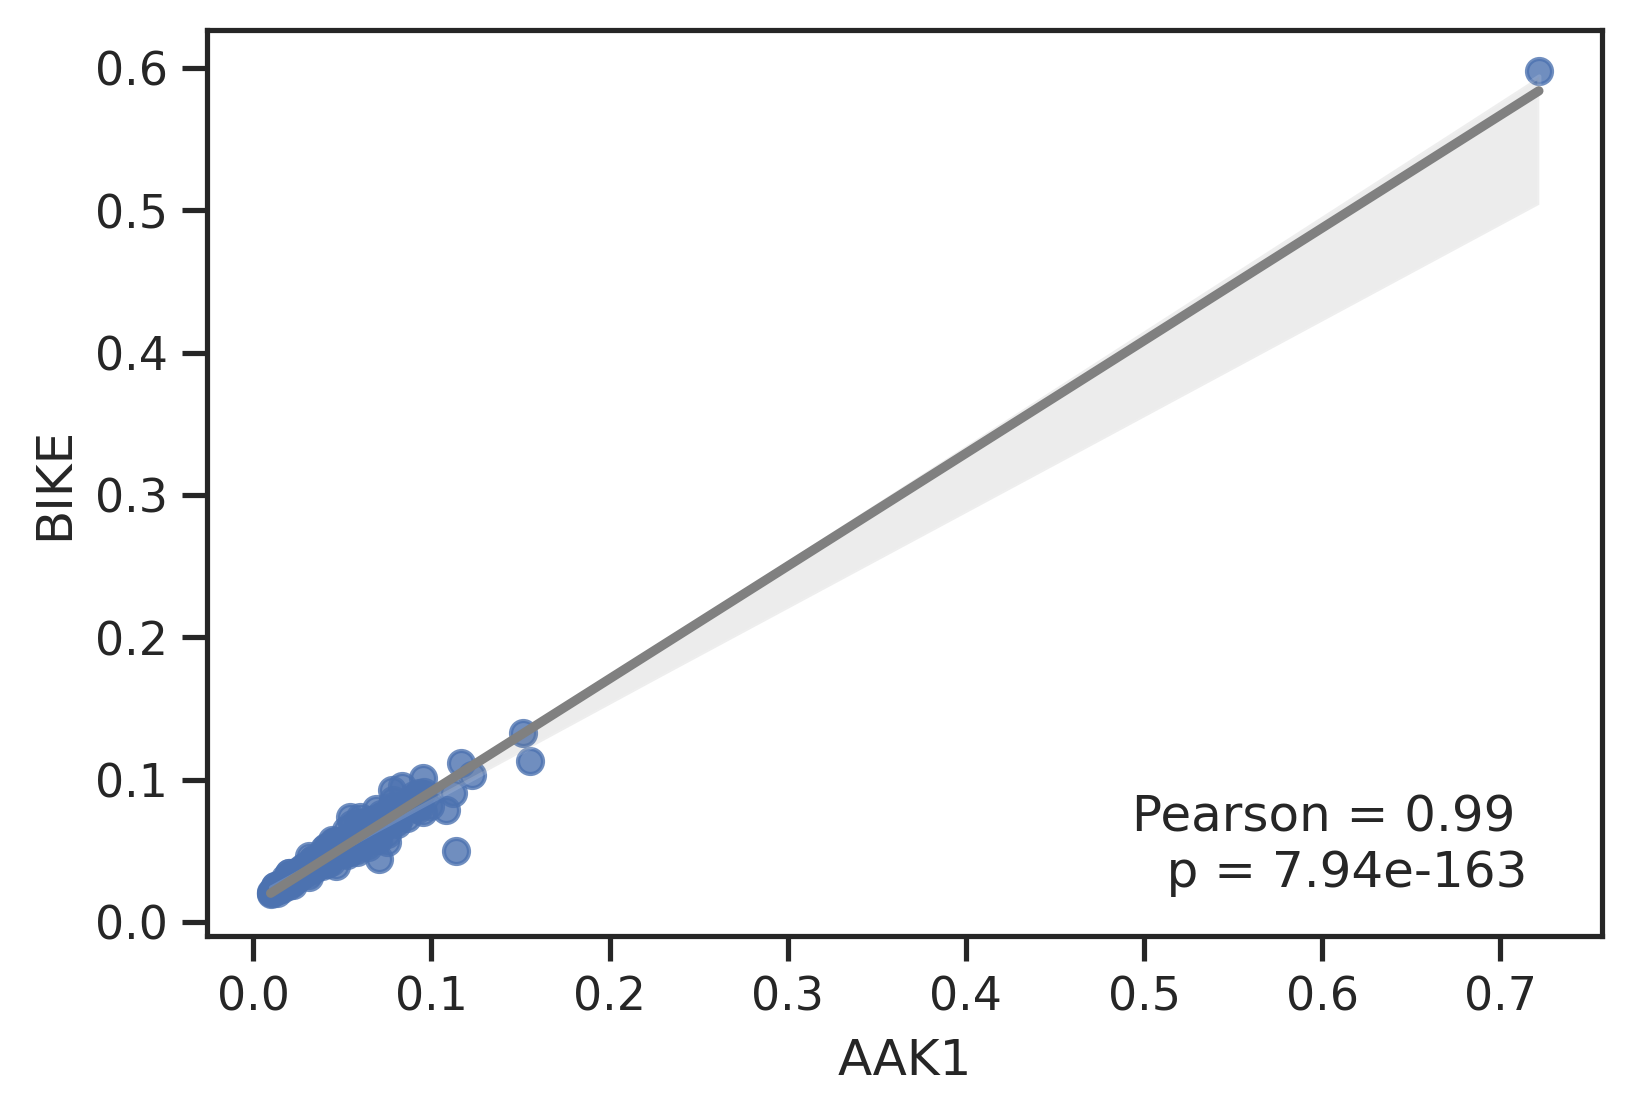

In [ ]:
plot_corr(data=norm.T, x='AAK1', y='BIKE')

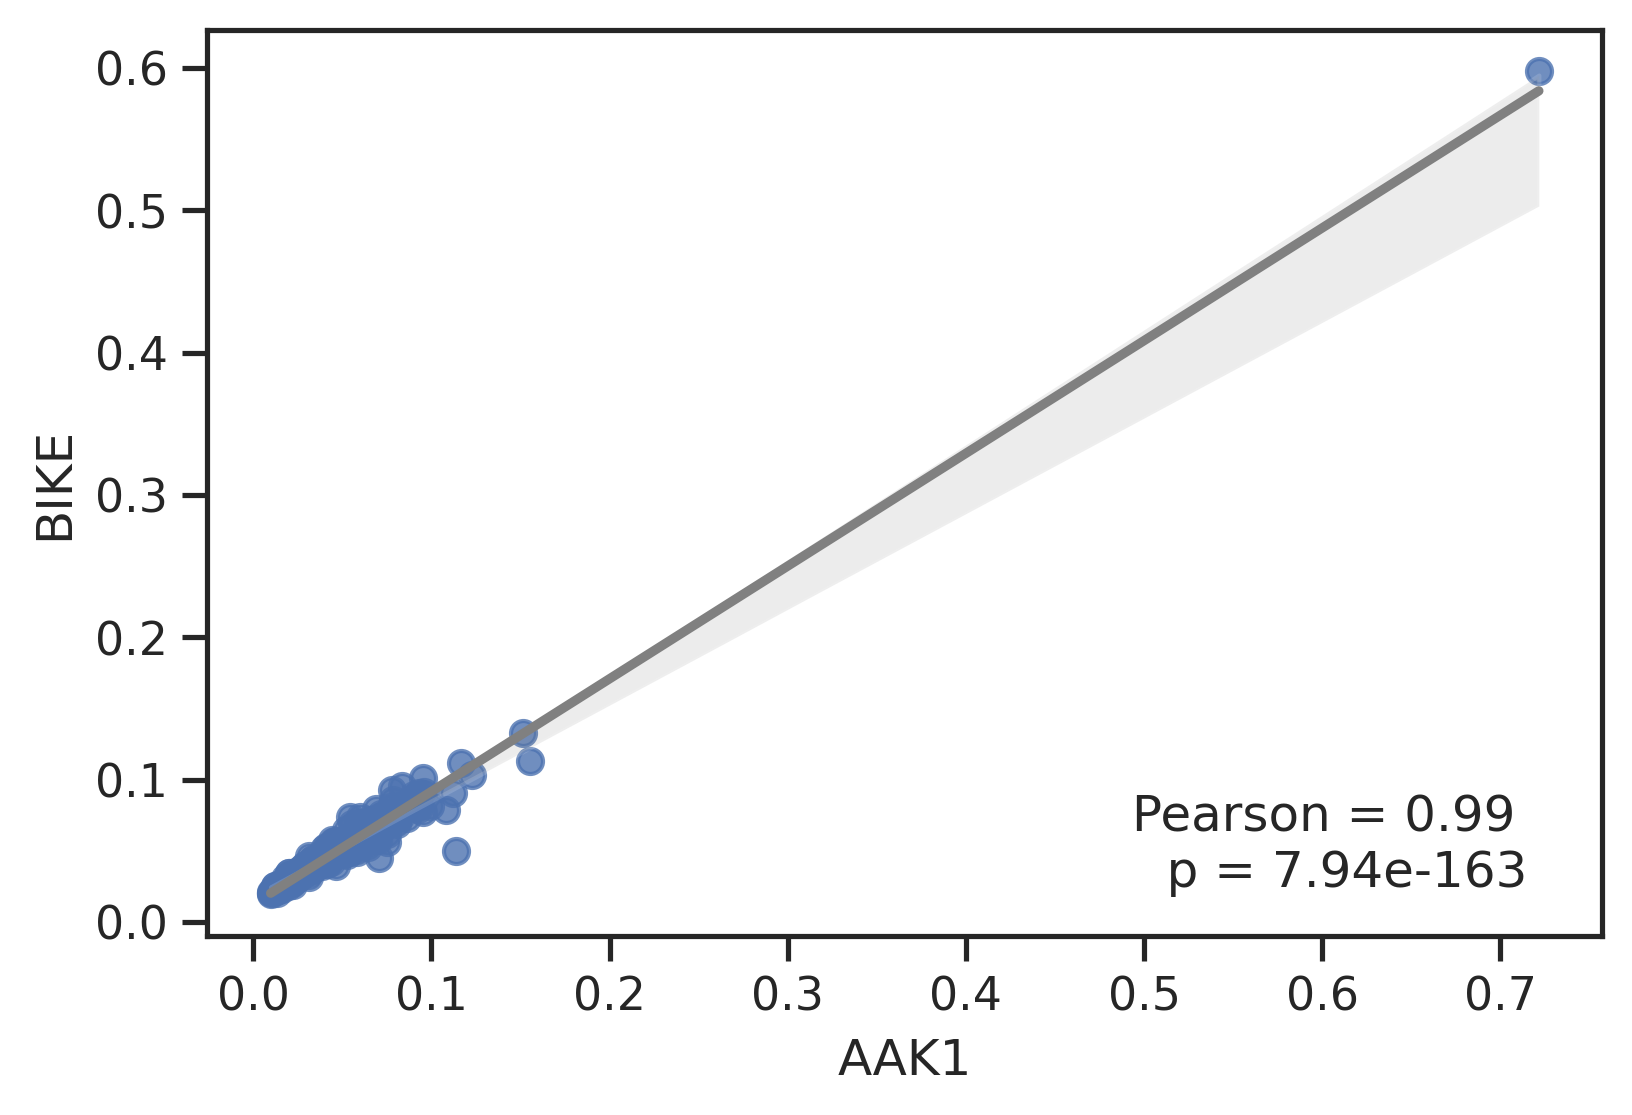

In [ ]:
plot_corr(norm.loc['AAK1'], norm.loc['BIKE'])

Draw heatmap of correlation

In [ ]:
#| export
def draw_corr(corr):
    # Mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Plotting the heatmap
    plt.figure(figsize=(20, 16))  # Set the figure size
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask, fmt='.2f')

In [ ]:
c = df.T.corr()

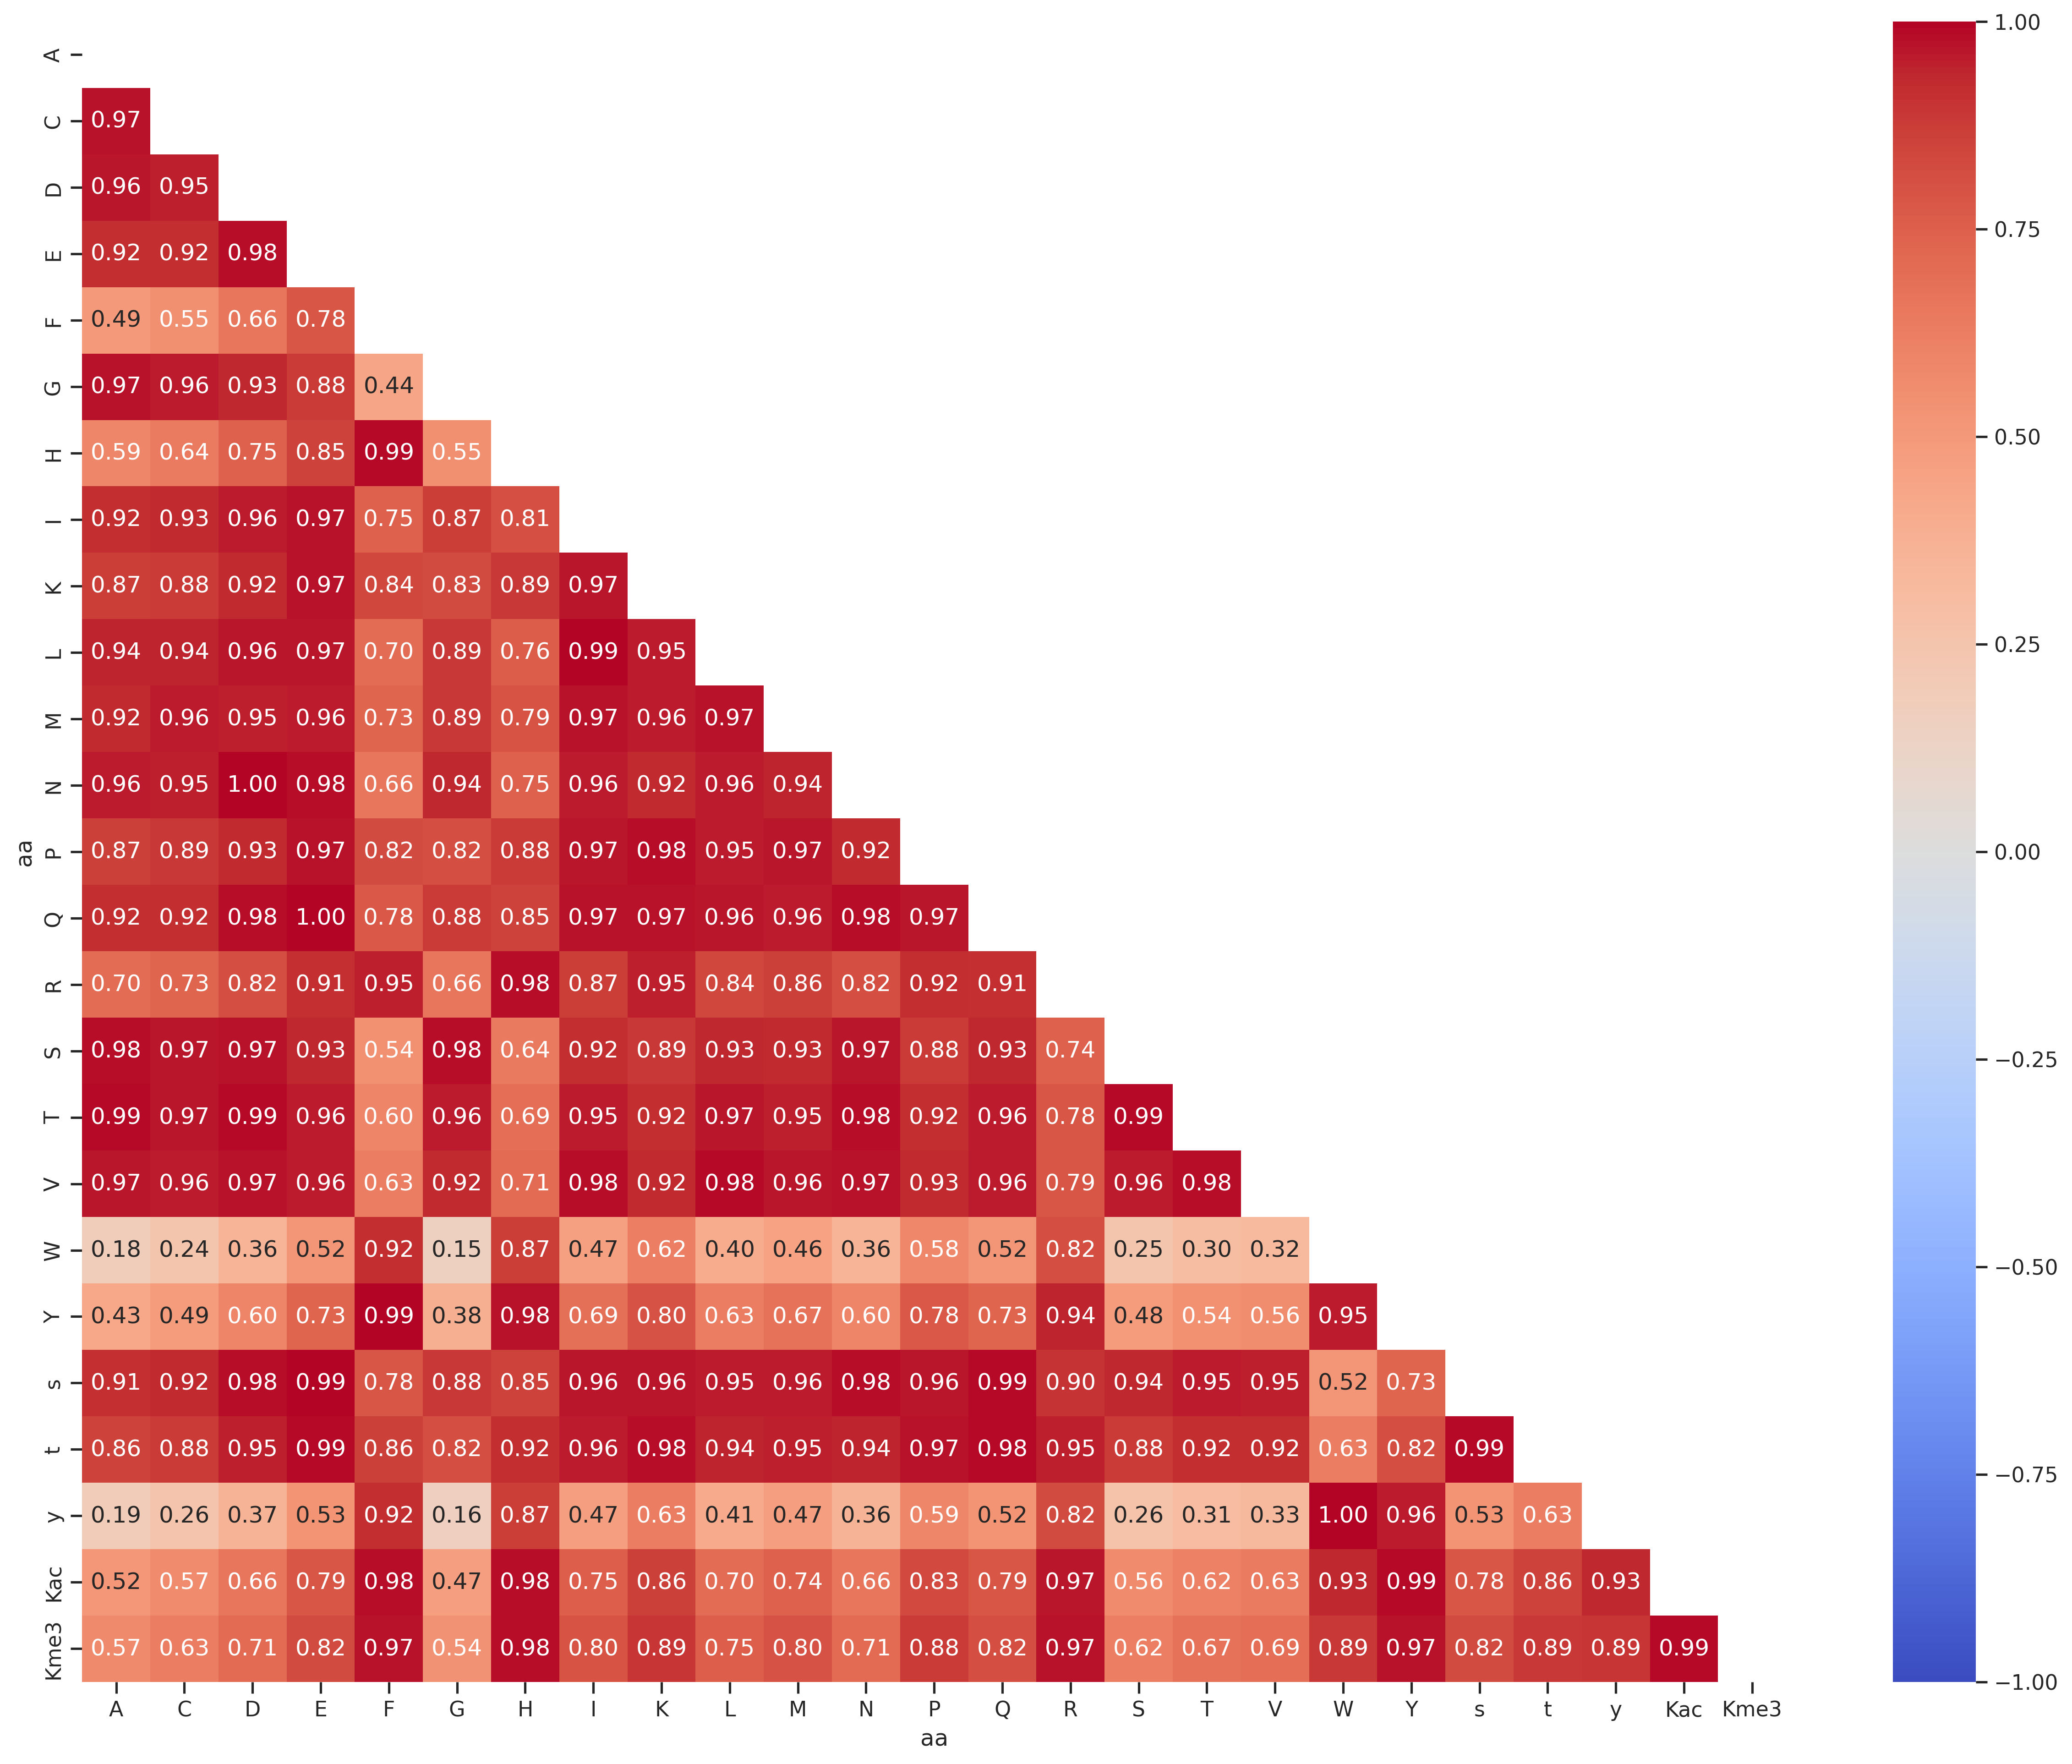

In [ ]:
draw_corr(c)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()